In [1]:
# External modules
import os.path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

start = time.time()


# Internal modules
import results
from initialize_model import m, S, V_meta
from global_param import Costs_u, Periods, Ext_T, Irradiance
import model
import data

Using license file c:\gurobi901\gurobi.lic
Academic license - for non-commercial use only
Reset all parameters
Discarded solution information
Changed value of parameter TimeLimit to 2000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


In [2]:
def var_names(m):
    var_name_time_indep, var_name_time_dep = [], []
    number = np.arange(0, 10).tolist()
    number = [str(n) for n in number]
    
    # get all variable names, store the time dependent ones and cut the period index
    for v in m.getVars():
        if all(n not in v.varName for n in number):
            if ',0' in v.varName:
                var_name_time_dep.append(v.varName.split(',0')[0])
            elif '[0' in v.varName:
                var_name_time_dep.append(v.varName.split('[0')[0])
            else:
                var_name_time_indep.append(v.varName)
                   
    return var_name_time_indep, var_name_time_dep


def var_results(m, Periods):
    var_result_time_indep, var_result_time_dep = {}, {}

    number = np.arange(0, 10).tolist()
    number = [str(n) for n in number]
    
    for v in m.getVars():
        results = []
        if ',0' in v.varName:
            name = v.varName.split(',0')[0]
            for p in Periods:
                results.append(m.getVarByName(name + ',{}]'.format(p)).x)
            var_result_time_dep[name + ']'] = results
        elif '[0' in v.varName:
            name = v.varName.split('[0')[0]
            for p in Periods:
                results.append(m.getVarByName(name + '[{}]'.format(p)).x)
            var_result_time_dep[name] = results
        elif all(n not in v.varName for n in number):
            var_result_time_indep[v.varName] = v.x
            
    return var_result_time_indep, var_result_time_dep

In [3]:
# Build and run the MIP optimization model
relax = False
model.run(relax)

end = time.time()
print('solve time model: ', end - start, 's')

var_result_time_indep, var_result_time_dep = var_results(m, Periods)
var_name_time_indep, var_name_time_dep = var_result_time_indep.keys(), var_result_time_dep.keys()

TypeError: can only concatenate str (not "bool") to str

In [4]:
var_result_time_indep

{'unit_size[BOI]': 510.29416427992516,
 'unit_size[PV]': 60.0,
 'unit_size[BAT]': 20.0,
 'unit_size[SOFC]': 20.0,
 'unit_size[AD]': 116.99999999999919,
 'unit_install[BOI]': 1.0,
 'unit_install[PV]': 1.0,
 'unit_install[BAT]': 1.0,
 'unit_install[SOFC]': 1.0,
 'unit_install[AD]': 1.0,
 'unit_capex[BOI]': 103.28559704890586,
 'unit_capex[PV]': 215.26715000000004,
 'unit_capex[BAT]': 26.6266,
 'unit_capex[SOFC]': 103.57560000000001,
 'unit_capex[AD]': 324.8999999999978,
 'min_T_AD': 30.0,
 'max_T_AD': 40.0,
 'penalty': 0.00013749392241885168,
 'grid_export_a[Elec]': 0.10027437629207056,
 'grid_export_a[Gas]': 0.0,
 'grid_import_a[Elec]': 3.493036385114797,
 'grid_import_a[Gas]': 27.215688761596002,
 'capex': 0.7736549470489037,
 'opex': 0.0030075618832518655,
 'totex': 0.052635305367661055}

In [24]:
def get_unit_name(var):
    return var.split('[')[1].split(']')[0]

Units_storage = ['BAT']
Color_code = {'BOI': 'firebrick', 'PV': 'aqua', 'BAT': 'navy', 
              'SOFC': 'red', 'AD': 'darkgreen'}
Units = ['BOI', 'PV', 'BAT', 'SOFC', 'AD']

def plot_unit_results(var_result_time_indep, Units, Units_storage, Color_code):
    """ Given a dictionnary of time independent results plot a bar chart of the size of units
        in kW of production capacity for non-storage units and in kWh for storage units.
    """

    fig, ax1 = plt.subplots()
    fig.set_size_inches(11.7, 5.8)
    plt.title('Installed capacity for each unit')
    ax2 = ax1.twinx()
    ax1.set_ylabel('Installed production capacity in kW')
    ax2.set_ylabel('Installed storage capacity in kWh')
    
    names = {}
    i, j = 0, len(Units) - len(Units_storage)
    for var in var_result_time_indep:
        if 'size' in var:
            name = get_unit_name(var)
            value = var_result_time_indep[var]
            if name not in Units_storage:
                ax1.bar(i, value)
                names[i] = name
                i += 1
            else:
                ax2.bar(j, value, color = Color_code[name])
                names[j] = name
                j += 1
                
    plt.xticks(range(len(Units)), [names[i] for i in range(len(Units))])

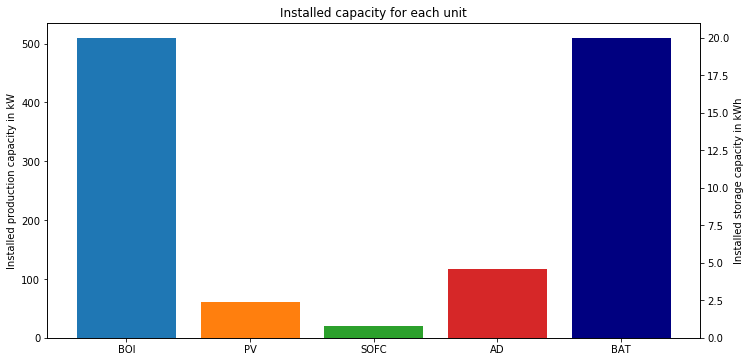

In [25]:
plot_unit_results(var_result_time_indep, Units, Units_storage, Color_code)
plt.show()

In [7]:
V_meta['Header'] = ['Name', 'Value', 'Lower Bound', 'Upper Bound', 'Units', 'Description']

In [8]:
def var_time_indep_summary(m, var_result_time_indep, V_meta):
    dic = {}
    for v in var_result_time_indep:
        dic[v] = [m.getVarByName(v).x]
        dic[v] += [m.getVarByName(v).lb, m.getVarByName(v).ub]
        if v in V_meta:
            dic[v] += V_meta[v]
            
    df = pd.DataFrame.from_dict(dic, orient='index')
    col = dict(zip([c for c in df.columns], V_meta['Header'][1:]))
    df.rename(columns = col, inplace = True)
    
    return df

In [9]:
pd.DataFrame(var_name_time_dep)

,0
0,unit_prod[BOI][Heat]
1,unit_cons[BOI][Gas]
2,unit_prod[PV][Elec]
3,unit_prod[BAT][Elec]
4,unit_cons[BAT][Elec]
5,unit_prod[SOFC][Elec]
6,unit_prod[SOFC][Heat]
7,unit_cons[SOFC][Gas]
8,unit_cons[SOFC][Biogas]
9,unit_prod[AD][Biogas]


In [10]:
def plot_stream_results(resource, var_result_time_dep):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-10-ad5dbc1dbae6>, line 2)

In [ ]:
resource = 'Elec'
elec = []
for name in var_name_time_dep:
    if resource in name:
        print(var_result_time_dep[name])

In [ ]:
from run import date
from global_param import Build_cons_elec

In [ ]:
resource = 'Elec'

def plot_resource(resource, var_result, var_name):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Electricity exchanged with units in kW')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Electricity exchanged with the grids and buildings in kW')

    for name in var_name:
        if resource in name:
            if 'grid' not in name:
                if 'prod' in name:
                    ax1.plot(date[:-1], var_result[name], label = name)
                else:
                    ax1.plot(date[:-1], [var_result[name][p]*(-1) for p in Periods], label = name)
            else:
                if 'import' in name:
                    ax2.plot(date[:-1], var_result[name], label = name, linestyle='--')
                else:
                    ax2.plot(date[:-1], [var_result[name][p]*(-1) for p in Periods], label = name, linestyle='--')
    
    if resource == 'Elec':
        ax2.plot(date[:-1], Build_cons_elec, label = 'Building consumption', linestyle='--')
        

    ax1.legend(loc='center left') 
    ax2.legend(loc='center right')
    
plot_resource('Elec', var_result_time_dep, var_name_time_dep)
plt.show()

In [ ]:
resource = 'Elec'

Color_code_u = {'BOI': 'firebrick', 'PV': 'aqua', 'BAT': 'navy', 'build_T': 'black', 'Ext_T': 'blue',
              'SOFC': 'orange', 'AD': 'darkgreen', 'Irradiance': 'red', 'bat_SOC': 'purple'}

def col(name):
    if '[' in name:
        name = get_unit_name(name)
    return Color_code[name]

def col(name):
    if '[' in name:
        name = get_unit_name(name)
    return Color_code[name]

def plot_units_resource(resource, var_result, var_name):
    plt.xlabel('Date and time')
    plt.ylabel(resource + 'exchanged with units in kW')

    for name in var_name:
        if resource in name:
            if 'prod' in name:
                plt.plot(date[:-1], var_result[name], label=name, c=col(name))
            elif 'cons' in name:
                plt.plot(date[:-1], [var_result[name][p]*(-1) for p in Periods], label=name, ls='--', c=col(name))


    plt.legend(loc='center left')

In [ ]:
col('Irradiance')

In [ ]:
plot_units_resource('Elec', var_result_time_dep, var_name_time_dep)
plt.show()

In [ ]:
plot_resource('Gas', var_result_time_dep, var_name_time_dep)
plt.show()

In [ ]:
plot_units_resource('Gas', var_result_time_dep, var_name_time_dep)
plt.show()

In [ ]:
def plot_PV_results(var_result, Irradiance):
    fig, ax1 = plt.subplots()
    plt.title('PV')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Electricity produced in kW')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Global Irradiance in kW/m^2')
    
    name = 'prod[PV][Elec]'
    ax1.plot(date[:-1], var_result[name], label = name, color=col(name))
    name = 'Irradiance'
    ax2.plot(date[:-1], Irradiance, label=name, color=col(name), linestyle='--')

    ax1.legend(loc='center left') 
    ax2.legend(loc='center right')
    
plot_PV_results(var_result_time_dep, Irradiance)
plt.show()

In [ ]:
def plot_BAT_results(var_result):
    fig, ax1 = plt.subplots()
    plt.title('Battery')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Electricity exchanged by the battery in kW')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Battery state of charge')
    
    name = 'prod[BAT][Elec]'
    ax1.plot(date[:-1], var_result[name], label = name, color=col(name))
    name = 'cons[BAT][Elec]'
    ax1.plot(date[:-1], var_result[name], label = name, color=col(name), linestyle='--')
    
    name = 'bat_SOC'
    ax2.plot(date[:-1], var_result[name], label=name, color=col(name))

    ax1.legend(loc='upper left') 
    ax2.legend(loc='upper right')
    
plot_BAT_results(var_result_time_dep)
plt.show()

In [ ]:
def plot_SOFC_results(var_result):
    fig, ax1 = plt.subplots()
    plt.title('SOFC')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Resources consumed and produced by the SOFC in kW')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Heat produced by the SOFC in kW')
    
    name = 'prod[SOFC][Elec]'
    ax1.plot(date[:-1], var_result[name], label = name, color=col(name))
    name = 'cons[SOFC][Gas]'
    ax1.plot(date[:-1], var_result[name], label = name, color=col(name), linestyle='--')
    name = 'cons[SOFC][Biogas]'
    ax1.plot(date[:-1], var_result[name], label = name, color=col(name), linestyle='--')
    
    name = 'prod[SOFC][Heat]'
    ax2.plot(date[:-1], var_result[name], label=name, color=col(name), linestyle='-.')

    ax1.legend(loc='upper left') 
    ax2.legend(loc='upper right')
    
plot_SOFC_results(var_result_time_dep)
plt.show()

In [ ]:
def normalize(l):
    return [l[i]/max(l) for i in range(len(l))]

In [ ]:
def plot_all_results(var_result, var_name):
    fig, ax1 = plt.subplots()
    plt.xlabel('Date')
    plt.ylabel('Variation')
    
    for v in var_name:
        if 'prod' in v  or 'cons' in v:
            variation = normalize(var_result[v])
            plt.title(v)
            plt.plot(date[:-1], variation, label = v)
    
    
plot_all_results(var_result_time_dep, var_name_time_dep)
plt.legend()
plt.show()

In [ ]:
marker_code = {'PV':'^', 'BAT':'d', 'BOI':'.', 'SOFC':'*', 'AD':'h', 'build': 's'}
color_code = {'Elec':'royalblue', 'Biogas':'limegreen', 'Gas': 'gray', 
              'Heat': 'firebrick', 'Ext_t': 'navy', 'Irradiance': 'red', 'Diesel': 'black'}
def col(name):
    if '[' in name:
        name = get_unit_name(name)
    return Color_code[name]

In [ ]:
v = list(var_name_time_dep)[0]

In [ ]:
min(var_result_time_dep[v])*1.05

In [ ]:
def plot_temperature_results(var_result):
    fig, ax1 = plt.subplots()
    plt.title('Weather and building temperatures')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Temperature in °C')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Global Irradiance in kW/m^2')
    
    name = 'build_T'
    ax1.plot(date[:-1], var_result[name], label = name, color=col(name))
    name = 'unit_T[AD]'
    ax1.plot(date[:-1], var_result[name], label = name, color=col(name))
    name = 'Ext_T'
    ax1.plot(date[:-1], Ext_T, label = name, color=col(name))
    
    name = 'Irradiance'
    ax2.plot(date[:-1], Irradiance, label=name, color=col(name))

    ax1.legend(loc='center left') 
    ax2.legend(loc='center right')
    
plot_temperature_results(var_result_time_dep)
plt.show()

In [ ]:

plt.rcParams['figure.figsize'] = [15, 5]
period_start = S['Period_start'] + ' ' + S['Period_start_time']
period_end = S['Period_end'] + ' ' + S['Period_start_time']
timestep = S['Time_step']
file = 'meteo_Liebensberg_10min.csv'

df_weather = data.weather_data_to_df(file, period_start, period_end, timestep)

date = df_weather.index
irr = df_weather['Irradiance']
temp = df_weather['Temperature']

fig, ax1 = plt.subplots()

c = 'red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Irradiance in kW')
ax1.plot(date, irr, color=c, label='Irradiance')
ax1.tick_params(axis='y', labelcolor=c)
fig.autofmt_xdate()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

c = 'blue'
ax2.set_ylabel('Temperature in °C')  # we already handled the x-label with ax1
ax2.plot(date, temp, color=c, label='Exterior Temperature')
ax2.tick_params(axis='y', labelcolor=c)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Weather data for Liebensberg from ' + S['Period_start']  + ' to ' + S['Period_end'] + 
          'and building temperatures')
    
ax2.plot(date[:-1], var_result_time_dep['build_T'], c='black', label='Building Temperature', ls='--')
ax2.plot(date[:-1], var_result_time_dep['unit_T[AD]'], c='green', label='AD Temperature')
plt.legend()

In [ ]:
a = np.random.randint(10, size=10)
a

In [ ]:
[a[i]/max(a) for i in a]

In [ ]:
os.path.join('results')

In [ ]:
import os
files=[]

files = [f for f in sorted(os.listdir('results\\run_on_2020-04-16\\'))]

In [ ]:
files

In [ ]:
[int(i) for i in files]

In [ ]:
max([int(i) for i in files])

In [ ]:
run_nbr = max([int(i) for i in files]) + 1

In [ ]:
now = datetime.now()
today = now.strftime("%Y-%m-%d")
cd = os.path.join('results', 'run_on_{}'.format(today), '{}'.format(run_nbr), '')
cd

In [ ]:
os.makedirs(os.path.dirname(cd), exist_ok=True)

In [ ]:
cd 

In [ ]:
s = 'cons[BAT][Elec]'

In [ ]:
Units += ['build']

In [ ]:
Units

In [ ]:
for u in Units + ['build']:
    if u in 'var_name_[]_buildLLL':
        name = u
name

In [ ]:
fig, axs = plt.subplots(3, 1, sharex=True)
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Plot each graph, and manually set the y tick values
axs[0].plot(t, s1)
axs[0].set_yticks(np.arange(-0.9, 1.0, 0.4))
axs[0].set_ylim(-1, 1)

axs[1].plot(t, s2)
axs[1].set_yticks(np.arange(0.1, 1.0, 0.2))
axs[1].set_ylim(0, 1)

axs[2].plot(t, s3)
axs[2].set_yticks(np.arange(-0.9, 1.0, 0.4))
axs[2].set_ylim(-1, 1)

plt.show()

In [ ]:
from global_param import Date, Ext_T, Irradiance, Build_cons_elec
from global_set import Units, Units_storage, Resources, Color_code, Marker_code
from run import var_result_time_dep, var_name_time_dep

def get_resource_name(var_name):
    """ Get the abbreviated name of a resoucre from a variable name string """
    name = []
    for r in Resources:
        if r in var_name:
            name.append(r)
    if not name:
        name.append('default')
    return(name[0])
        
def get_unit_name(var_name):
    """ Get the abbreviated name of a unit from a variable name string """
    name = []
    for u in Units + ['build', 'grid']:
        if u in var_name:
            name.append(u)
    if not name:
        name.append('default')
    return(name[0])

def col(var_name):
    """ Return the color code of a corresponding unit """
    r = get_resource_name(var_name)
    return Color_code[r]

def mark(var_name):
    """ Return the marker code of a corresponding resource """
    u = get_unit_name(var_name)
    print(u, var_name)
    return Marker_code[u]

In [ ]:
def resource(resource, var_result, var_name):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Electricity exchanged with units in kW')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Electricity exchanged with the grids and buildings in kW')

    for n in var_name:
        if resource in n:
            if 'grid' not in n:
                if 'prod' in n:
                    ax1.scatter(Date, var_result[n], label=n, c=col(n), marker=mark(n))
                else:
                    ax1.scatter(Date, [var_result[n][p]*(-1) for p in Periods], 
                             label=n, c=col(n), marker=mark(n))
            else:
                if 'import' in n:
                    ax2.scatter(Date, var_result[n], label=n, c=col(n), marker=mark(n))
                else:
                    ax2.scatter(Date, [var_result[n][p]*(-1) for p in Periods], 
                             label=n, c=col(n), marker=mark(n))
    
    if resource == 'Elec':
        ax2.scatter(Date, Build_cons_elec, label = 'Building consumption', c=col('Elec'), marker=mark(n))
        

    ax1.legend(loc='center left') 
    ax2.legend(loc='center right')

In [ ]:
Resources

In [ ]:
var_name

In [ ]:
for v in var_name:
    print(v)
    name = []
    for r in Resources:
        if r in v:
            name.append(r)
    if not name:
        name.append('Default')
    print(name[0])

In [ ]:
for n in var_name:
    print(n)
    print('max', max(var_result[n]))
    print('min', min(var_result[n]))
    if max(var_result[n]) <= 1.25*min(var_result[n]):
        var_name.remove(n)
var_name

In [ ]:

fig, axs = plt.subplots(len(var_name), 1, sharex=True)
fig.set_size_inches(20, 50)
plt.xlabel('Date')
fig.subplots_adjust(hspace=0)
i = 0
for n in var_name:
    axs[i].plot(Date, var_result[n], label=n, c=col(n))
    axs[i].legend()
    axs[i].set_ylabel(get_resource_name(n))
    i += 1

In [ ]:
P={'AD':{'eff': 2}}

In [ ]:
P['AD']['eff']